<a href="https://colab.research.google.com/github/KRiver28/TIL/blob/master/popcorn(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Word Embedding & CNN을 이용한 감성분석
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pickle


In [3]:
DATA_PATH = '/content/drive/MyDrive/'

# 학습 데이터를 읽어온다.
with open(DATA_PATH + 'popcorn.pkl', 'rb') as f:
    x_text, _, y_target, _ = pickle.load(f)

y_target = np.array(y_target).reshape(-1,1)

In [5]:

# 사전이 너무 크다. 줄여보자.
VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(x_text)
x_feat = tokenizer.texts_to_sequences(x_text)
word2idx = {k:v for k, v in tokenizer.word_index.items() if v < VOCAB_SIZE}
word2idx['<PAD>'] = 0

# 각 리뷰의 길이를 max_seq_len로 맞춘다. 길면 자르고, 짧으면 padding을 추가한다.
MAX_SEQ_LEN = 174
x_data_pad = pad_sequences(x_feat, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# 학습 데이터와 시험 데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data_pad, y_target, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20000, 174), (5000, 174), (20000, 1), (5000, 1))

In [6]:
# CNN 모델을 빌드한다.
VOCAB_SIZE = len(word2idx)
EMB_SIZE = 32
NUM_FILTER = 32

# Convolution & Pooling
def conv1d_maxpool(x, k):
    conv = Conv1D(filters=NUM_FILTER, kernel_size=k, activation='relu',
               kernel_regularizer=regularizers.l2(0.005))(x)
    return GlobalMaxPool1D()(conv)

x_input = Input(batch_shape=(None, x_train.shape[1]))
emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
emb = Dropout(rate=0.5)(emb)

pool1 = conv1d_maxpool(emb, k=3)  # 3-gram
pool2 = conv1d_maxpool(emb, k=4)  # 4-gram
pool3 = conv1d_maxpool(emb, k=5)  # 5-gram
concat = Concatenate()([pool1, pool2, pool3])
y_output = Dense(1, activation='sigmoid')(concat)

model = Model(x_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 174, 32)      640000      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 174, 32)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 172, 32)      3104        ['dropout[0][0]']                
                                                                                              

Epoch 1/30
20/20 [==============================] - 14s 614ms/step - loss: 1.1376 - val_loss: 1.0907
Epoch 2/30
20/20 [==============================] - 12s 600ms/step - loss: 1.0549 - val_loss: 1.0157
Epoch 3/30
20/20 [==============================] - 12s 600ms/step - loss: 0.9856 - val_loss: 0.9530
Epoch 4/30
20/20 [==============================] - 12s 599ms/step - loss: 0.9278 - val_loss: 0.9004
Epoch 5/30
20/20 [==============================] - 12s 598ms/step - loss: 0.8788 - val_loss: 0.8554
Epoch 6/30
20/20 [==============================] - 12s 597ms/step - loss: 0.8357 - val_loss: 0.8147
Epoch 7/30
20/20 [==============================] - 12s 613ms/step - loss: 0.7946 - val_loss: 0.7743
Epoch 8/30
20/20 [==============================] - 12s 595ms/step - loss: 0.7508 - val_loss: 0.7303
Epoch 9/30
20/20 [==============================] - 12s 595ms/step - loss: 0.7008 - val_loss: 0.6820
Epoch 10/30
20/20 [==============================] - 12s 594ms/step - loss: 0.6484 - val_lo

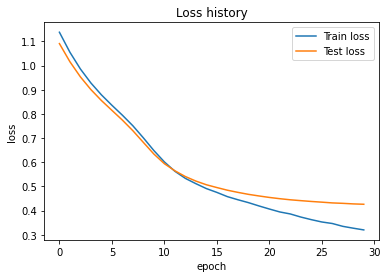

In [7]:
# 학습
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 1024, epochs = 30)

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [8]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 83.90 %
